In [4]:
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
!pip install --user pymc
!pip install --upgrade setuptools numpy


 %% [markdown]
 # Bayesian Inference with Hierarchical Priors
 
 - Each gene has its own log expression "offset" drawn from (mu_gene, sigma_gene).
 - Each condition has its own log intercept "offset" drawn from (mu_cond, sigma_cond).
 - This treats genes and conditions as categories in a hierarchical model.
 - We compare the posterior means of these offsets to the *true* values.

Simulated Data (first 10 rows):
     Gene    Condition  True_Expression  Condition_Intercept  Gene_Length  \
0  Gene_1  Condition_1         6.572745             1.281918  2215.089704   
1  Gene_1  Condition_2         6.572745             0.933203  2215.089704   
2  Gene_1  Condition_3         6.572745             1.382432  2215.089704   
3  Gene_1  Condition_4         6.572745             2.141518  2215.089704   
4  Gene_1  Condition_5         6.572745             0.889517  2215.089704   
5  Gene_2  Condition_1        16.274613             1.281918  1341.048247   
6  Gene_2  Condition_2        16.274613             0.933203  1341.048247   
7  Gene_2  Condition_3        16.274613             1.382432  1341.048247   
8  Gene_2  Condition_4        16.274613             2.141518  1341.048247   
9  Gene_2  Condition_5        16.274613             0.889517  1341.048247   

   Observed_Counts  
0                5  
1                0  
2                0  
3                1  
4              

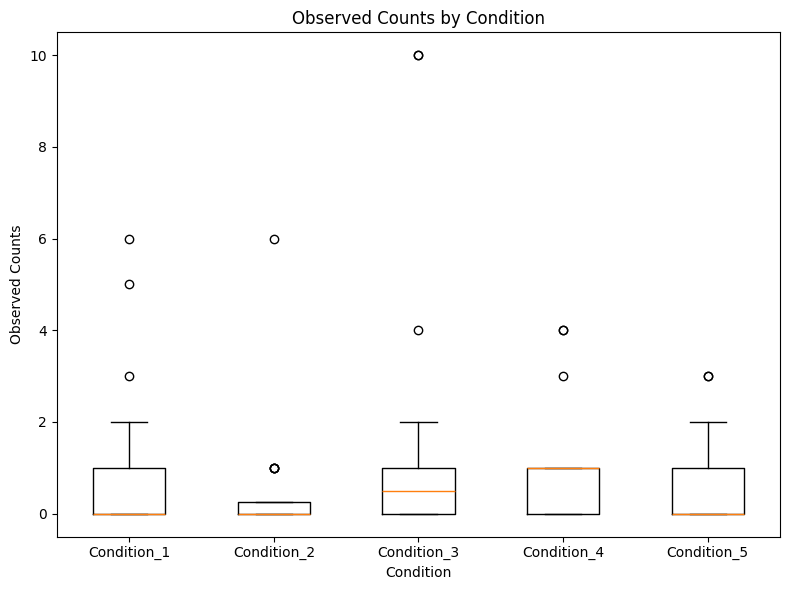

In [1]:
# %% [markdown]
# # Simulation: Negative Binomial Counts

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

# --------------------------
# Simulation Parameters
# --------------------------
n_genes = 20
n_conditions = 5

# Simulate condition intercepts on log-scale
condition_log_intercepts = np.random.normal(loc=0.0, scale=0.5, size=n_conditions)
condition_intercepts = np.exp(condition_log_intercepts)

# Simulate true gene expression on log-scale
true_log_expression = np.random.normal(loc=2.0, scale=0.5, size=n_genes)
true_expression = np.exp(true_log_expression)

# Sequencing Depth and Gene Length
seq_depth = 1e4
gene_lengths = np.random.uniform(low=1000, high=3000, size=n_genes)

# Overdispersion (phi = 1 means moderate overdispersion)
phi = 1.0

# Reference values for scaling
ref_seq_depth = 1e5
ref_gene_length = 2000.0

# --------------------------
# Simulate Observed Read Counts
# --------------------------
observed_counts = np.zeros((n_genes, n_conditions), dtype=int)
for g in range(n_genes):
    for c in range(n_conditions):
        base_mean = true_expression[g] * condition_intercepts[c]
        scaled_mean = base_mean * (seq_depth / ref_seq_depth) * (gene_lengths[g] / ref_gene_length)
        r = 1.0 / phi
        p = r / (r + scaled_mean)
        observed_counts[g, c] = np.random.negative_binomial(r, p)

# Prepare a long-format DataFrame for inspection
data_records = []
for g in range(n_genes):
    for c in range(n_conditions):
        data_records.append({
            'Gene': f'Gene_{g+1}',
            'Condition': f'Condition_{c+1}',
            'True_Expression': true_expression[g],
            'Condition_Intercept': condition_intercepts[c],
            'Gene_Length': gene_lengths[g],
            'Observed_Counts': observed_counts[g, c]
        })
df_simulated = pd.DataFrame(data_records)

print("Simulated Data (first 10 rows):")
print(df_simulated.head(10))

# Quick boxplot
plt.figure(figsize=(8,6))
conditions = df_simulated['Condition'].unique()
data_by_condition = [df_simulated[df_simulated['Condition'] == cond]['Observed_Counts'] 
                     for cond in conditions]
plt.boxplot(data_by_condition, labels=conditions)
plt.title("Observed Counts by Condition")
plt.xlabel("Condition")
plt.ylabel("Observed Counts")
plt.tight_layout()
plt.show()


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_gene, sigma_gene, gene_log_expression, mu_cond, sigma_cond, condition_intercepts_log, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2157 seconds.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


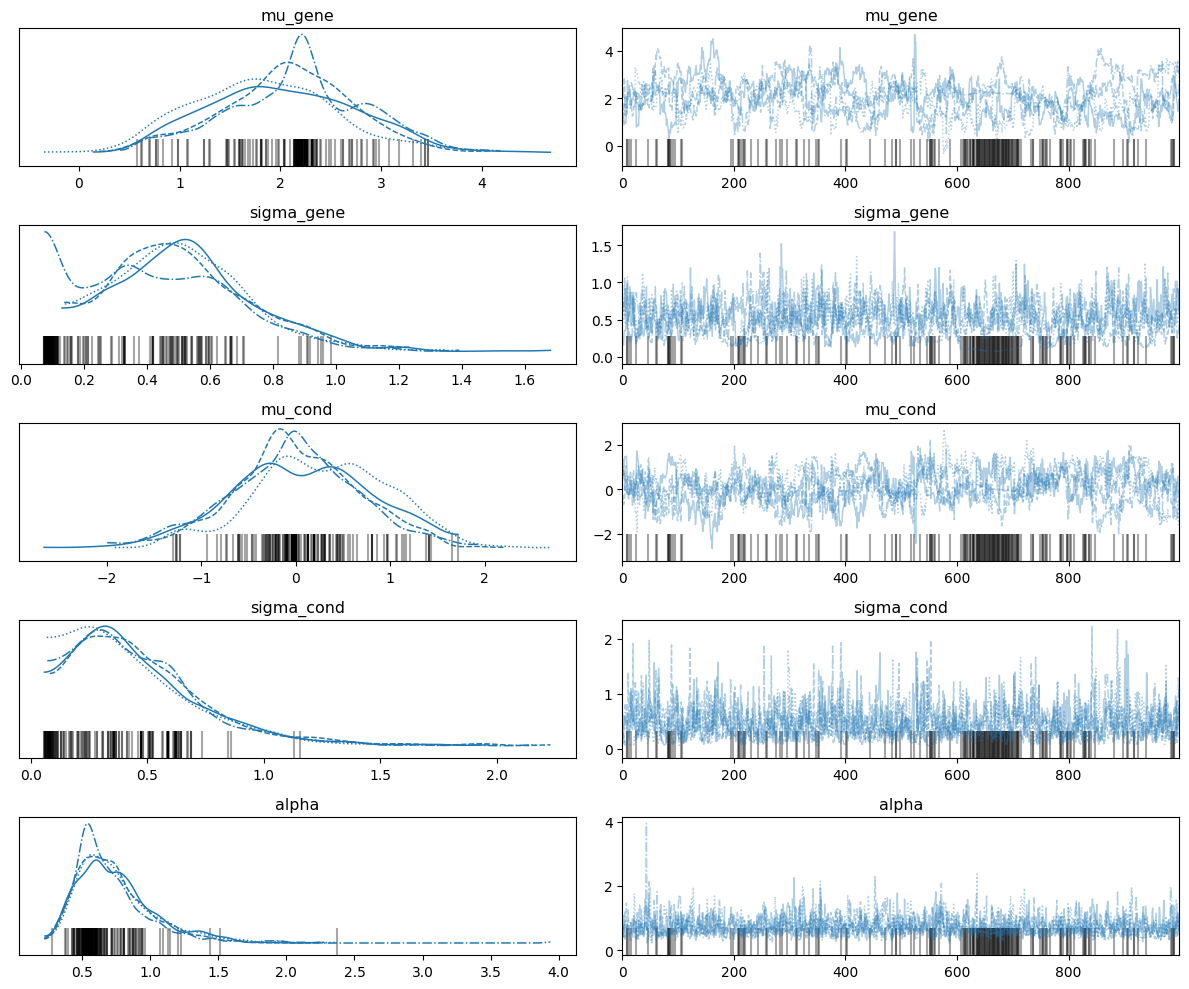

True Gene Log Expression vs Posterior Means:
Gene_1: true=1.88, post_mean=2.13
Gene_2: true=2.79, post_mean=2.21
Gene_3: true=2.38, post_mean=2.07
Gene_4: true=1.77, post_mean=1.84
Gene_5: true=2.27, post_mean=2.25
Gene_6: true=1.77, post_mean=2.01
Gene_7: true=1.77, post_mean=1.89
Gene_8: true=2.12, post_mean=1.97
Gene_9: true=1.04, post_mean=1.59
Gene_10: true=1.14, post_mean=1.84
Gene_11: true=1.72, post_mean=2.15
Gene_12: true=1.49, post_mean=1.73
Gene_13: true=2.16, post_mean=2.11
Gene_14: true=1.55, post_mean=2.01
Gene_15: true=1.29, post_mean=1.98
Gene_16: true=2.73, post_mean=2.76
Gene_17: true=1.89, post_mean=1.79
Gene_18: true=2.03, post_mean=2.27
Gene_19: true=1.29, post_mean=1.98
Gene_20: true=1.73, post_mean=1.81

True Condition Log Intercepts vs Posterior Means:
Condition_1: true=0.25, post_mean=0.06
Condition_2: true=-0.07, post_mean=-0.20
Condition_3: true=0.32, post_mean=0.37
Condition_4: true=0.76, post_mean=0.28
Condition_5: true=-0.12, post_mean=-0.04


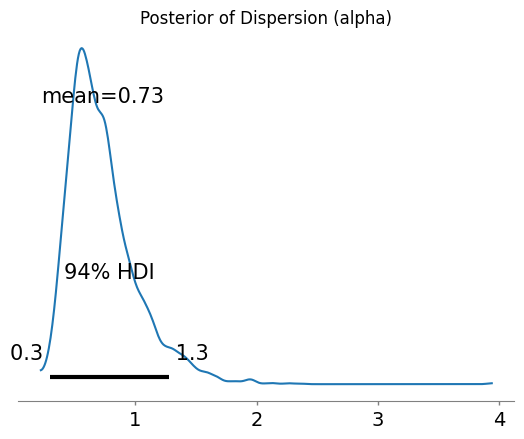

In [3]:


import pymc as pm
import arviz as az

with pm.Model() as model:
    # --------------------------
    # Gene-level random intercepts
    # --------------------------
    mu_gene = pm.Normal("mu_gene", mu=2.0, sigma=1.0)        # global average for genes
    sigma_gene = pm.HalfNormal("sigma_gene", sigma=1.0)      # how much genes vary around mu_gene
    gene_log_expression = pm.Normal(
        "gene_log_expression",
        mu=mu_gene,
        sigma=sigma_gene,
        shape=n_genes
    )

    # --------------------------
    # Condition-level random intercepts
    # --------------------------
    mu_cond = pm.Normal("mu_cond", mu=0.0, sigma=1.0)        # global average for conditions
    sigma_cond = pm.HalfNormal("sigma_cond", sigma=1.0)      # how much conditions vary around mu_cond
    condition_intercepts_log = pm.Normal(
        "condition_intercepts_log",
        mu=mu_cond,
        sigma=sigma_cond,
        shape=n_conditions
    )

    # --------------------------
    # Dispersion (alpha > 0)
    # --------------------------
    alpha = pm.HalfCauchy('alpha', beta=2)

    # --------------------------
    # Compute the mean expression
    # --------------------------
    # log_mu[g, c] = gene_log_expression[g] + condition_intercepts_log[c]
    #              + log(seq_depth/ref_seq_depth) + log(gene_length[g]/ref_gene_length)
    log_mu = gene_log_expression[:, None] + condition_intercepts_log[None, :]
    log_mu += np.log(seq_depth / ref_seq_depth)
    log_mu += np.log(gene_lengths[:, None] / ref_gene_length)

    mu = pm.Deterministic("mu", pm.math.exp(log_mu))

    # --------------------------
    # Likelihood: Negative Binomial
    # --------------------------
    observed = pm.NegativeBinomial(
        'observed',
        mu=mu,
        alpha=alpha,
        observed=observed_counts
    )

    # Sample from the posterior
    trace = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.9,
        return_inferencedata=True
    )

# %%
# Posterior Analysis: Compare to True Values

# Plot or print summary of the main parameters
az.plot_trace(trace, var_names=["mu_gene", "sigma_gene", "mu_cond", "sigma_cond", "alpha"])
plt.tight_layout()
plt.show()

# Compare posterior means to the true gene/condition values used in simulation
post_gene_log_expr = trace.posterior["gene_log_expression"].mean(dim=("chain", "draw")).values
post_cond_log_int = trace.posterior["condition_intercepts_log"].mean(dim=("chain", "draw")).values

print("True Gene Log Expression vs Posterior Means:")
for i in range(n_genes):
    print(f"Gene_{i+1}: true={true_log_expression[i]:.2f}, post_mean={post_gene_log_expr[i]:.2f}")

print("\nTrue Condition Log Intercepts vs Posterior Means:")
for j in range(n_conditions):
    print(f"Condition_{j+1}: true={condition_log_intercepts[j]:.2f}, post_mean={post_cond_log_int[j]:.2f}")

# Posterior for alpha
az.plot_posterior(trace, var_names=['alpha'])
plt.title("Posterior of Dispersion (alpha)")
plt.show()


In [4]:
az.summary(trace)
           

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_gene,2.023,0.726,0.621,3.276,0.100,0.071,54.0,223.0,1.07
gene_log_expression[0],2.133,0.826,0.511,3.602,0.079,0.056,109.0,484.0,1.05
gene_log_expression[1],2.210,0.830,0.575,3.715,0.102,0.072,65.0,336.0,1.05
gene_log_expression[2],2.070,0.823,0.516,3.615,0.104,0.074,62.0,308.0,1.06
gene_log_expression[3],1.844,0.845,0.318,3.470,0.117,0.083,53.0,307.0,1.06
...,...,...,...,...,...,...,...,...,...
"mu[19, 0]",0.520,0.313,0.068,1.006,0.008,0.006,1057.0,2308.0,1.01
"mu[19, 1]",0.412,0.248,0.047,0.850,0.008,0.006,433.0,1616.0,1.01
"mu[19, 2]",0.709,0.449,0.112,1.407,0.013,0.009,1047.0,1663.0,1.01
"mu[19, 3]",0.645,0.367,0.111,1.270,0.013,0.009,712.0,1514.0,1.01


In [5]:
import arviz as az

# Define a list of the hierarchical parameters (exclude gene_log_expression and mu)
hierarchical_vars = ["mu_gene", "sigma_gene", "mu_cond", "sigma_cond", "alpha"]

# Generate the summary for these parameters only
hierarchical_summary = az.summary(trace, var_names=hierarchical_vars)
print(hierarchical_summary)


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_gene     2.023  0.726   0.621    3.276      0.100    0.071      54.0   
sigma_gene  0.497  0.224   0.077    0.877      0.025    0.018      54.0   
mu_cond     0.085  0.717  -1.286    1.414      0.085    0.060      72.0   
sigma_cond  0.456  0.289   0.059    0.963      0.010    0.007     682.0   
alpha       0.734  0.288   0.296    1.281      0.009    0.006    1371.0   

            ess_tail  r_hat  
mu_gene        223.0   1.07  
sigma_gene      34.0   1.06  
mu_cond        304.0   1.06  
sigma_cond     725.0   1.01  
alpha         1804.0   1.01  


# Bayesian Inference with Hierarchical Non-Centered Parameterization

Using non-centered parameterization for both the gene-level and condition-level intercepts.
Instead of sampling gene_log_expression directly as Normal(mu_gene, sigma_gene),
we sample z_gene ~ Normal(0, 1) and then set:
    gene_log_expression = mu_gene + sigma_gene * z_gene

We do the same for condition intercepts.


In [2]:

import pymc as pm
import numpy as np
import arviz as az

with pm.Model() as model:
    # --------------------------
    # Gene-level non-centered parameterization
    # --------------------------
    mu_gene = pm.Normal("mu_gene", mu=2.0, sigma=1.0)       # Global average for gene log-expression
    sigma_gene = pm.HalfNormal("sigma_gene", sigma=1.0)       # Variability among genes
    z_gene = pm.Normal("z_gene", mu=0, sigma=1, shape=n_genes)  # Auxiliary standard normal for genes
    gene_log_expression = pm.Deterministic("gene_log_expression", mu_gene + sigma_gene * z_gene)
    
    # --------------------------
    # Condition-level non-centered parameterization
    # --------------------------
    mu_cond = pm.Normal("mu_cond", mu=0.0, sigma=1.0)        # Global average for condition log-intercepts
    sigma_cond = pm.HalfNormal("sigma_cond", sigma=1.0)        # Variability among conditions
    z_cond = pm.Normal("z_cond", mu=0, sigma=1, shape=n_conditions)  # Auxiliary standard normal for conditions
    condition_intercepts_log = pm.Deterministic("condition_intercepts_log", mu_cond + sigma_cond * z_cond)
    
    # --------------------------
    # Dispersion (alpha > 0)
    # --------------------------
    alpha = pm.HalfCauchy('alpha', beta=2)
    
    # --------------------------
    # Compute the mean expression
    # --------------------------
    # log_mu[g, c] = gene_log_expression[g] + condition_intercepts_log[c]
    #              + log(seq_depth/ref_seq_depth) + log(gene_length[g]/ref_gene_length)
    log_mu = gene_log_expression[:, None] + condition_intercepts_log[None, :]
    log_mu += np.log(seq_depth / ref_seq_depth)
    log_mu += np.log(gene_lengths[:, None] / ref_gene_length)
    
    mu = pm.Deterministic("mu", pm.math.exp(log_mu))
    
    # --------------------------
    # Likelihood: Negative Binomial
    # --------------------------
    observed = pm.NegativeBinomial('observed', mu=mu, alpha=alpha, observed=observed_counts)
    
    # Sample from the posterior
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_gene, sigma_gene, z_gene, mu_cond, sigma_cond, z_cond, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1453 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


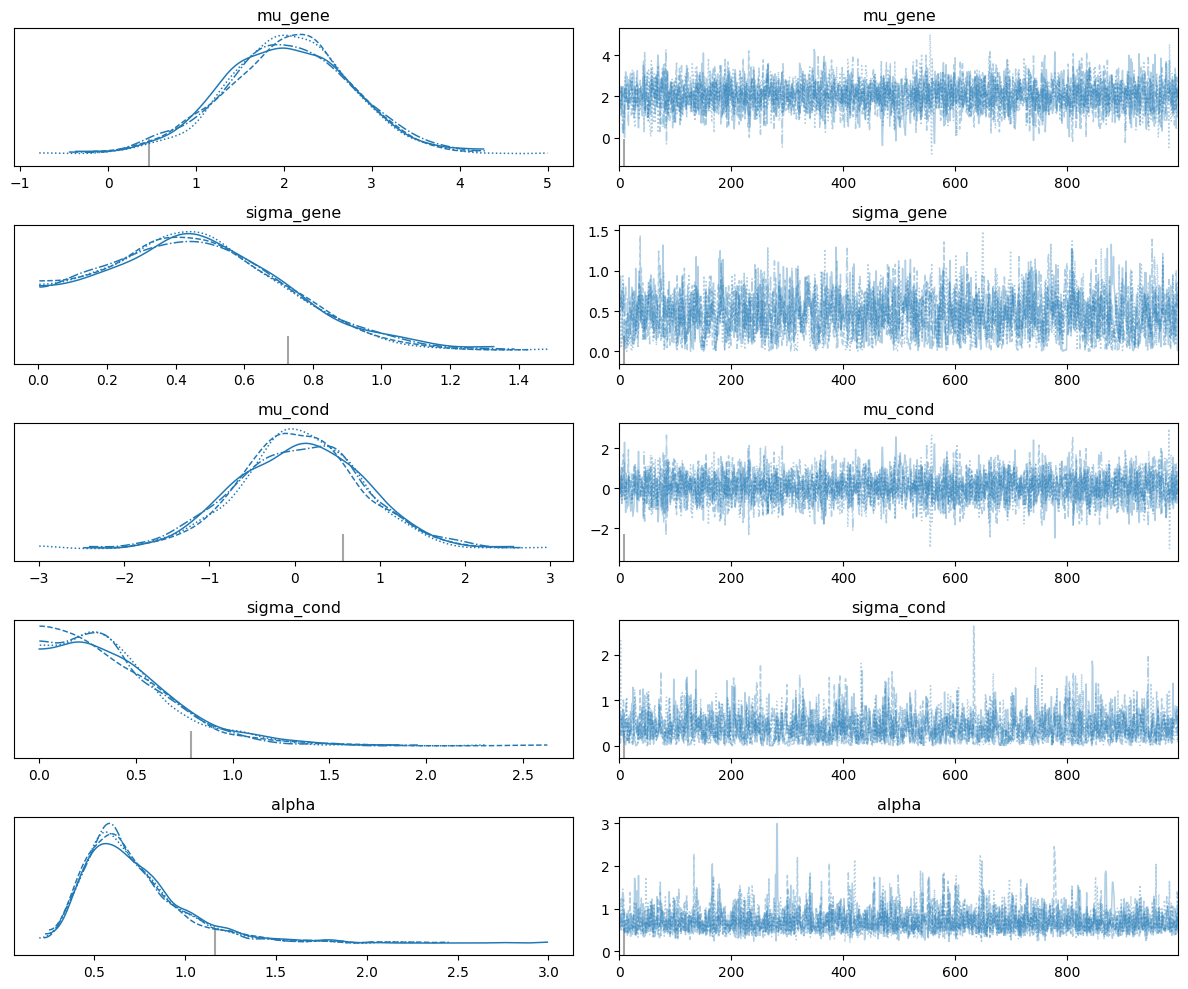

True Gene Log Expression vs Posterior Means:
Gene_1: true=1.88, post_mean=2.14
Gene_2: true=2.79, post_mean=2.22
Gene_3: true=2.38, post_mean=2.10
Gene_4: true=1.77, post_mean=1.88
Gene_5: true=2.27, post_mean=2.28
Gene_6: true=1.77, post_mean=2.04
Gene_7: true=1.77, post_mean=1.93
Gene_8: true=2.12, post_mean=2.00
Gene_9: true=1.04, post_mean=1.65
Gene_10: true=1.14, post_mean=1.89
Gene_11: true=1.72, post_mean=2.17
Gene_12: true=1.49, post_mean=1.79
Gene_13: true=2.16, post_mean=2.13
Gene_14: true=1.55, post_mean=2.03
Gene_15: true=1.29, post_mean=2.02
Gene_16: true=2.73, post_mean=2.72
Gene_17: true=1.89, post_mean=1.82
Gene_18: true=2.03, post_mean=2.28
Gene_19: true=1.29, post_mean=2.02
Gene_20: true=1.73, post_mean=1.84

True Condition Log Intercepts vs Posterior Means:
Condition_1: true=0.25, post_mean=0.05
Condition_2: true=-0.07, post_mean=-0.18
Condition_3: true=0.32, post_mean=0.31
Condition_4: true=0.76, post_mean=0.23
Condition_5: true=-0.12, post_mean=-0.04


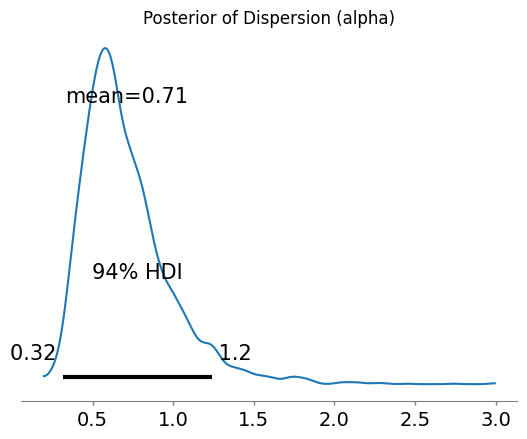

In [3]:
# %%
# Posterior Analysis: Compare to True Values

# Plot or print summary of the main parameters
az.plot_trace(trace, var_names=["mu_gene", "sigma_gene", "mu_cond", "sigma_cond", "alpha"])
plt.tight_layout()
plt.show()

# Compare posterior means to the true gene/condition values used in simulation
post_gene_log_expr = trace.posterior["gene_log_expression"].mean(dim=("chain", "draw")).values
post_cond_log_int = trace.posterior["condition_intercepts_log"].mean(dim=("chain", "draw")).values

print("True Gene Log Expression vs Posterior Means:")
for i in range(n_genes):
    print(f"Gene_{i+1}: true={true_log_expression[i]:.2f}, post_mean={post_gene_log_expr[i]:.2f}")

print("\nTrue Condition Log Intercepts vs Posterior Means:")
for j in range(n_conditions):
    print(f"Condition_{j+1}: true={condition_log_intercepts[j]:.2f}, post_mean={post_cond_log_int[j]:.2f}")

# Posterior for alpha
az.plot_posterior(trace, var_names=['alpha'])
plt.title("Posterior of Dispersion (alpha)")
plt.show()


In [4]:
import arviz as az

# Define a list of the hierarchical parameters (exclude gene_log_expression and mu)
hierarchical_vars = ["mu_gene", "sigma_gene", "mu_cond", "sigma_cond", "alpha"]

# Generate the summary for these parameters only
hierarchical_summary = az.summary(trace, var_names=hierarchical_vars)
print(hierarchical_summary)


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_gene     2.050  0.727   0.619    3.397      0.012    0.009    3686.0   
sigma_gene  0.454  0.258   0.003    0.882      0.006    0.004    1528.0   
mu_cond     0.067  0.727  -1.290    1.417      0.012    0.012    3659.0   
sigma_cond  0.399  0.300   0.000    0.926      0.007    0.005    1621.0   
alpha       0.712  0.280   0.317    1.244      0.005    0.004    3703.0   

            ess_tail  r_hat  
mu_gene       2793.0    1.0  
sigma_gene    1688.0    1.0  
mu_cond       2753.0    1.0  
sigma_cond    1756.0    1.0  
alpha         2546.0    1.0  


In [5]:
az.summary()

TypeError: summary() missing 1 required positional argument: 'data'

In [ ]:
az.plot_posterior(trace, ref_val=0)